In [1]:
import os

import gym
import numpy as np
import pandas as pd
import seaborn as sns

from ray import init, rllib, tune, shutdown

In [2]:
from attack_simulator.agents import DEFENDERS
from attack_simulator.alphazero_env import AttackSimulationAlphaZeroEnv
from attack_simulator.env import AttackSimulationEnv
from attack_simulator.graph import AttackGraph, SIZES

In [3]:
class AgentPolicy(rllib.policy.Policy):
    def __init__(self, observation_space, action_space, config):
        super().__init__(observation_space, action_space, config)
        agent_config = dict(
            input_dim=observation_space.shape[0],
            num_actions=action_space.n,
            random_seed=config["seed"],
            attack_graph=config["env_config"]["attack_graph"],
        )
        self._agent = DEFENDERS[config["agent_type"]](agent_config)

    def compute_actions(self, observations, *args, **kwargs):
        # FIXME: use a `numpy` array as a temporary workaround for
        #        https://github.com/ray-project/ray/issues/10100
        return np.array([self._agent.act(obs) for obs in observations]), [], {}

    def get_weights(self):
        return {}

    def set_weights(self, weights):
        pass

    def learn_on_batch(self, samples):
        return {}


def template_agent(agent_type):
    default_config = rllib.agents.trainer.with_common_config(dict(agent_type=agent_type))
    return rllib.agents.trainer_template.build_trainer(
        name=agent_type,
        default_policy=AgentPolicy,
        default_config=default_config,
    )

In [4]:
# 'contrib/AlphaZero' does NOT appear to work without its custom dense model
from ray.rllib.contrib.alpha_zero.models.custom_torch_models import DenseModel

rllib.models.ModelCatalog.register_custom_model("alpha_zero_dense_model", DenseModel)

In [5]:
from ray.util.client import worker

worker.INITIAL_TIMEOUT_SEC = worker.MAX_TIMEOUT_SEC = 1


def ray_init():
    if os.path.isdir("/var/run/secrets/kubernetes.io") or os.path.exists(
        os.path.expanduser("~/ray_bootstrap_config.yaml")
    ):
        # inside k8s pod or a cluster managed by Ray's autoscaler
        context = init(address="auto")
    else:
        ray_client_server = "host.docker.internal" if os.path.exists("/.dockerenv") else "127.0.0.1"
        try:
            context = init(address=f"ray://{ray_client_server}:10001")
        except ConnectionError:
            # clean up after failed connection attempt
            shutdown()
            # listen on all interfaces inside a container for port-forwarding to work
            dashboard_host = "0.0.0.0" if os.path.exists("/.dockerenv") else "127.0.0.1"
            context = init(num_cpus=4, dashboard_host=dashboard_host)
    print("\x1b[33;1m", context, "\x1b[m")
    return context

In [6]:
agent_types = ["contrib/AlphaZero", "R2D2", "rule-based", "random"]
graphs = [AttackGraph(dict(graph_size=size)) for size in SIZES]
seeds = [0, 1, 2, 3, 6, 7, 11, 28, 42, 1337]
iterations = 10
rollouts = 10

common_config = dict(
    # log_level='DEBUG',
    framework="torch",
    env=AttackSimulationEnv,
    env_config=dict(attack_graph=tune.grid_search(graphs)),
    seed=tune.grid_search(seeds),
    # common evaluation settings
    evaluation_num_workers=1,
    evaluation_config=dict(
        explore=False,
        # workaround for a bug in RLLib (https://github.com/ray-project/ray/issues/17921)
        replay_sequence_length=-1,
    ),
    evaluation_num_episodes=rollouts,
)
train_and_eval_config = dict(
    common_config,
    num_workers=2,
    # evaluation at the end
    evaluation_interval=iterations,
)
eval_only_config = dict(
    common_config,
    # evaluation ONLY: avoid MultiGPU optimizer, set all relevant sizes to 0
    simple_optimizer=True,
    num_workers=0,
    train_batch_size=0,
    rollout_fragment_length=0,
    timesteps_per_iteration=0,
    # evaluation at the end
    evaluation_interval=1,
)

AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)
AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)
AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)
AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)
AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)
AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)
AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)


In [7]:
rename = {
    "config.env_config.agent_type": "Agent",
    "config.env_config.attack_graph": "graph",
    "evaluation.hist_stats.episode_reward": "returns",
    "evaluation.hist_stats.episode_lengths": "lengths",
}


def postprocess(results_df):
    df = results_df[rename.keys()].rename(columns=rename)
    df.dropna(inplace=True)  # remove `NaN` evaluation results from failed trials
    df["Graph size"] = df["graph"].apply(lambda g: g.num_attacks)
    del df["graph"]
    df["tuple"] = df.apply(lambda t: list(zip(t.returns, t.lengths)), axis="columns")
    del df["returns"]
    del df["lengths"]
    df = df.explode("tuple", ignore_index=True)
    df[["Returns", "Episode lengths"]] = df["tuple"].tolist()
    del df["tuple"]
    return df

In [8]:
def generate(savename):
    ray_init()

    frames = []
    for agent_type in agent_types:
        if agent_type in DEFENDERS:
            agent = template_agent(agent_type)
            config = dict(eval_only_config)
            stop = dict(training_iteration=0)
        else:
            agent = agent_type
            if agent_type == "contrib/AlphaZero":
                config = dict(
                    train_and_eval_config,
                    env=AttackSimulationAlphaZeroEnv,
                    model=dict(custom_model="alpha_zero_dense_model"),
                    rollout_fragment_length=32,
                    train_batch_size=640,
                    buffer_size=512,
                )
            else:
                config = dict(train_and_eval_config, model=dict(use_lstm=True))

            stop = dict(training_iteration=iterations)  # TODO: additional stopping criteria?

        config["env_config"].update(agent_type=agent_type)
        results = tune.run(
            agent,
            config=config,
            stop=stop,
            max_failures=3,
            queue_trials=True,
            raise_on_failed_trial=False,
            progress_reporter=tune.JupyterNotebookReporter(overwrite=True),
            sync_config=tune.SyncConfig(sync_to_driver=False),
        )
        frames.append(results.results_df)

    shutdown()
    results_df = pd.concat(frames, ignore_index=True)
    df = postprocess(results_df)
    df.to_csv(savename)
    return df

In [9]:
savename = "returns-tune-eval.csv"

df = generate(savename) if not os.path.exists(savename) else pd.read_csv(savename, index_col=0)

Trial name,status,loc,env_config/attack_graph,seed
random_AttackSimulationEnv_45ce5_00000,ERROR,127.0.0.1:27922,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",0
random_AttackSimulationEnv_45ce5_00001,ERROR,127.0.0.1:27923,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",0
random_AttackSimulationEnv_45ce5_00002,ERROR,127.0.0.1:27946,"AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)",0
random_AttackSimulationEnv_45ce5_00003,ERROR,127.0.0.1:27947,"AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)",0
random_AttackSimulationEnv_45ce5_00004,ERROR,127.0.0.1:27972,"AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)",0
random_AttackSimulationEnv_45ce5_00005,ERROR,127.0.0.1:27977,"AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)",0
random_AttackSimulationEnv_45ce5_00006,ERROR,127.0.0.1:27996,"AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)",0
random_AttackSimulationEnv_45ce5_00007,ERROR,127.0.0.1:28001,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",1
random_AttackSimulationEnv_45ce5_00008,ERROR,127.0.0.1:28020,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",1
random_AttackSimulationEnv_45ce5_00009,ERROR,127.0.0.1:28025,"AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)",1


(pid=28772) [2021-11-17 15:42:28,773 E 28772 1085965] raylet_client.cc:159: IOError: Broken pipe [RayletClient] Failed to disconnect from raylet.
2021-11-17 15:42:28,915	ERROR tune.py:626 -- Trials did not complete: [random_AttackSimulationEnv_45ce5_00000, random_AttackSimulationEnv_45ce5_00001, random_AttackSimulationEnv_45ce5_00002, random_AttackSimulationEnv_45ce5_00003, random_AttackSimulationEnv_45ce5_00004, random_AttackSimulationEnv_45ce5_00005, random_AttackSimulationEnv_45ce5_00006, random_AttackSimulationEnv_45ce5_00007, random_AttackSimulationEnv_45ce5_00008, random_AttackSimulationEnv_45ce5_00009, random_AttackSimulationEnv_45ce5_00010, random_AttackSimulationEnv_45ce5_00011, random_AttackSimulationEnv_45ce5_00012, random_AttackSimulationEnv_45ce5_00013, random_AttackSimulationEnv_45ce5_00014, random_AttackSimulationEnv_45ce5_00015, random_AttackSimulationEnv_45ce5_00016, random_AttackSimulationEnv_45ce5_00017, random_AttackSimulationEnv_45ce5_00018, random_AttackSimulation

In [10]:
sns.set(style="darkgrid", rc={"figure.figsize": (12, 8)})

Text(0.5, 1.0, 'Returns vs Size (random attacker)')

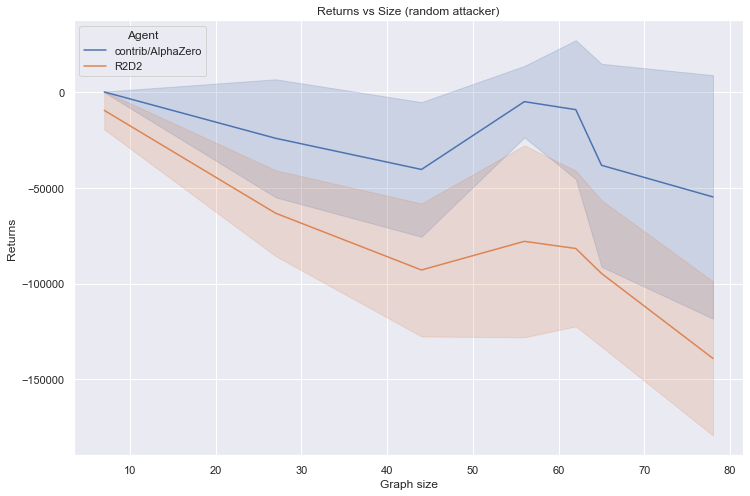

In [11]:
g = sns.lineplot(data=df, x="Graph size", y="Returns", hue="Agent", ci="sd")
g.legend(title="Agent", loc="upper left")
g.set_title("Returns vs Size (random attacker)")

Text(0.5, 1.0, 'Episode lengths vs Size (random attacker)')

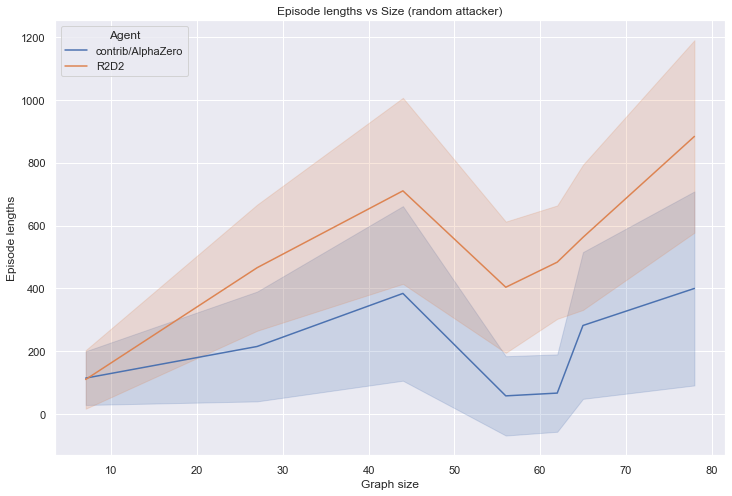

In [12]:
g = sns.lineplot(data=df, x="Graph size", y="Episode lengths", hue="Agent", ci="sd")
g.legend(title="Agent", loc="upper left")
g.set_title("Episode lengths vs Size (random attacker)")

In [13]:
# pd.set_option("display.max_columns", 32)
df.groupby("Agent").describe()

Graph size                                               \
                       count       mean        std  min   25%   50%   75%   
Agent                                                                       
R2D2                   700.0  48.428571  22.649012  7.0  27.0  56.0  65.0   
contrib/AlphaZero      700.0  48.428571  22.649012  7.0  27.0  56.0  65.0   

                        Returns                ...                   \
                    max   count          mean  ...      75%     max   
Agent                                          ...                    
R2D2               78.0   700.0 -79828.232857  ... -43756.5   252.0   
contrib/AlphaZero  78.0   700.0 -24391.745714  ...    404.0  7523.0   

                  Episode lengths                                             \
                            count        mean         std  min    25%    50%   
Agent                                                                          
R2D2                        700.0  516.987143  319.134288  3.0  301.0  485.0   
contrib/AlphaZero           700.0  217.144286  244.138896  8.0   39.0  119.0   

                                   
                      75%     max  
Agent                              
R2D2               699.25  1937.0  
contrib/AlphaZero  302.25  1239.0  

[2 rows x 24 columns]